[CountyHealthRankings](https://www.countyhealthrankings.org/health-data/methodology-and-sources/data-documentation)

This new Python code is necessary because some descriptions in the official data dictionary for CHR files are inaccurate. After selecting the factors, we refer back to the data dictionary to verify them and make manual corrections if needed

In [66]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import os

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [160]:
data_dir = "..\\data\\"
intermediate_dir = "..\\intermediate\\"
documentation_dir = "..\\documentation\\"
today = "20250402"

# Data Dictionary

> Extract All Measures

In [68]:
all_measures = {}
not_selected_dict = {}
shapes_dict = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".xlsx") and 'CHR_DD' in filename:
        year = filename[:4]
        df = pd.read_excel(os.path.join(data_dir, filename))

        original_shape = df.shape
        ##mask = df['Variable Name'].str.contains("_numerator|_denominator|_cilow|_cihigh|race|other_data|flag", case=False)
        mask = df['Variable Name'].str.contains("_cilow|_cihigh|race|other_data|flag", case=False)
        filtered_df = df[~mask]
        not_selected_dict[year] = df[mask]['Variable Name'].tolist()

        shapes_dict[year] = {"before": original_shape, "after": filtered_df.shape}

        all_measures[year] = [
            (row['Variable Name'], row['Measure'], row.get('Description', None))
            for _, row in filtered_df.iterrows() # _ indicates the index
        ]

C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\hongy\AppData\Roaming\Python\Python311\site-packages\openpy

In [69]:
not_selected_dict

{'2011': ['v001_cilow',
  'v001_cihigh',
  'v002_cilow',
  'v002_cihigh',
  'v036_cilow',
  'v036_cihigh',
  'v042_cilow',
  'v042_cihigh',
  'v037_cilow',
  'v037_cihigh',
  'v009_cilow',
  'v009_cihigh',
  'v011_cilow',
  'v011_cihigh',
  'v049_cilow',
  'v049_cihigh',
  'v039_cilow',
  'v039_cihigh',
  'v045_cilow',
  'v045_cihigh',
  'v014_cilow',
  'v014_cihigh',
  'v003_cilow',
  'v003_cihigh',
  'v004_cilow',
  'v004_cihigh',
  'v004_other_data_1',
  'v005_cilow',
  'v005_cihigh',
  'v007_cilow',
  'v007_cihigh',
  'v050_cilow',
  'v050_cihigh',
  'v021_cilow',
  'v021_cihigh',
  'v069_cilow',
  'v069_cihigh',
  'v023_cilow',
  'v023_cihigh',
  'v024_cilow',
  'v024_cihigh',
  'v040_cilow',
  'v040_cihigh',
  'v082_cilow',
  'v082_cihigh',
  'v043_cilow',
  'v043_cihigh',
  'v015_cilow',
  'v015_cihigh',
  'v046_cilow',
  'v046_cihigh',
  'v029_cilow',
  'v029_cihigh',
  'v030_cilow',
  'v030_cihigh',
  'v068_cilow',
  'v068_cihigh',
  'v060_cilow',
  'v060_cihigh',
  'v061_cilo

> Read Combined Data Dictionary

In [70]:
data = []
total_years = len(all_measures)

for year, variables in all_measures.items():
    for var_name, measure, description in variables:
        data.append((year, var_name, measure, description))

df = pd.DataFrame(data, columns=["Year", "Variable Name", "Measure", "Description"])
df.sort_values(by=["Variable Name", "Year"]).to_csv(f"{intermediate_dir}measures.csv", index=False)

In [71]:
df

,Year,Variable Name,Measure,Description
0,2011,statecode,State FIPS Code,None
1,2011,countycode,County FIPS Code,None
2,2011,fipscode,5-digit FIPS Code,None
3,2011,state,State Abbreviation,None
4,2011,county,Name,None
...,...,...,...,...
3282,2022,v057_numerator,% female numerator,
3283,2022,v057_denominator,% female denominator,
3284,2022,v058_rawvalue,% rural raw value,Percentage of population living in a rural area.
3285,2022,v058_numerator,% rural numerator,


## Align Data Dictionary
> Render Syntax
+ make all values in `Variable Name`, `Measure`, and `Description` all in lower cases - for better match purposes
+ For column `Measure`: 
    + replace "\n" with " "
    + replace the ending period with ""
    + replace "females" to "female"
+ For column `Description`:
    + replace "\n" with " "

In [72]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

df["Measure"] = (
    df["Measure"]
    .str.replace("\n", " ", regex=False)
    .str.replace(r"\.$", "", regex=True)
    .str.replace("females", "female")
    .str.replace("&", "and", regex=False)
)

df["Description"] = df["Description"].str.replace("\n", " ", regex=False)#.str.replace(r"\.$", "", regex=True)

## Selected Factors

In [73]:
selected_var = pd.read_csv(f'{documentation_dir}cleaned_dataset_dd.csv')

> Select only the factors we want to focus on

In [74]:
selected_var.head(5)

,Variable Name,Measure,Description,formula,formula_description,colname
0,v002_rawvalue,Poor or fair health raw value,Percentage of adults reporting fair or poor health (age-adjusted).,v002_rawvalue * (1 - v052_rawvalue) * v051_rawvalue,Adjusted total number of adults reporting fair or poor health,poor_or_fair_health
1,v003_rawvalue,Uninsured adults raw value,Percentage of adults under age 65 without health insurance.,v003_rawvalue * (1 - v053_rawvalue) * v051_rawvalue,Total uninsured adults under age 65,uninsured_adults
2,v004_rawvalue,Primary care physicians raw value,"Number of primary care physicians per 100,000 population",v004_rawvalue * (v051_rawvalue / 100_000),Total primary care physicians,primary_care_physicians
3,v009_rawvalue,Adult smoking raw value,Percentage of adults who are current smokers (age-adjusted).,v009_rawvalue * (1 - v052_rawvalue) * v051_rawvalue,Adjusted total number of adults who are current smokers,adult_smoking
4,v011_rawvalue,Adult obesity raw value,Percentage of the adult population (age 18 and older) that reports a body mass index (BMI) greater than or\nequal to 30 kg/m2 (age-adjusted).,v011_rawvalue * (1 - v052_rawvalue) * v051_rawvalue,Adjusted total number of adults classified as obese,adult_obesity


In [126]:
base_vars = [
    'v009', # adult smoking #
    'v011', # adult obesity #
    'v045', # sti #
    'v049', # excessive drinking #
    'v051', # pop raw #
    'v052', # Percentage of population below 18 years of age. #
    'v060',  # diabetes prevalence #
    #'v132' # Percentage of population with adequate access to locations for physical activity #
    'v070', # Percentage of adults age 18 and over reporting no leisure-time physical activity (age-adjusted).
    'v069', # some college
    'v023', # unemployment
    'v082', # children in single-parent households
    'v062', # mental health providers
    'v063', # median household income
    'v067'#, # driving alone to work
    #'v140'# social association
]
base_vars

['v009',
 'v011',
 'v045',
 'v049',
 'v051',
 'v052',
 'v060',
 'v070',
 'v069',
 'v023',
 'v082',
 'v062',
 'v063',
 'v067']

In [127]:
# add other values, not factors, that start with 'v' and contain '_'
valid_list=['statecode',
            'countycode',
            'fipscode',
            'state',
            'county',
            'year']

# extract factors values that are selected factors
for i in df['Variable Name'].unique().tolist():
    print(i)
    if i.startswith('v') and '_' in i:
        if i.split('_')[0] in base_vars:
            valid_list.append(i)

print(valid_list)

statecode
countycode
fipscode
state
county
year
county_ranked
v001_rawvalue
v001_numerator
v001_denominator
v002_rawvalue
v002_numerator
v002_denominator
v036_rawvalue
v036_numerator
v036_denominator
v042_rawvalue
v042_numerator
v042_denominator
v037_rawvalue
v037_numerator
v037_denominator
v009_rawvalue
v009_numerator
v009_denominator
v011_rawvalue
v011_numerator
v011_denominator
v049_rawvalue
v049_numerator
v049_denominator
v039_rawvalue
v039_numerator
v039_denominator
v045_rawvalue
v045_numerator
v045_denominator
v014_rawvalue
v014_numerator
v014_denominator
v003_rawvalue
v003_numerator
v003_denominator
v004_rawvalue
v004_numerator
v004_denominator
v005_rawvalue
v005_numerator
v005_denominator
v007_rawvalue
v007_numerator
v007_denominator
v050_rawvalue
v050_numerator
v050_denominator
v021_rawvalue
v021_numerator
v021_denominator
v069_rawvalue
v069_numerator
v069_denominator
v023_rawvalue
v023_numerator
v023_denominator
v024_rawvalue
v024_numerator
v024_denominator
v040_rawvalue
v040

In [128]:
len(valid_list)

48

In [129]:
selected_dd = df[df['Variable Name'].isin(valid_list)]
print(f'The shape of the data dictionary before selecting these factors is {df.shape}, and after selecting, it is {selected_dd.shape}.')

The shape of the data dictionary before selecting these factors is (3287, 4), and after selecting, it is (576, 4).


In [130]:
selected_dd

,Year,Variable Name,Measure,Description
0,2011,statecode,state fips code,None
1,2011,countycode,county fips code,None
2,2011,fipscode,5-digit fips code,None
3,2011,state,state abbreviation,None
4,2011,county,name,None
...,...,...,...,...
3252,2022,v051_numerator,population numerator,
3253,2022,v051_denominator,population denominator,
3254,2022,v052_rawvalue,% below 18 years of age raw value,percentage of population below 18 years of age.
3255,2022,v052_numerator,% below 18 years of age numerator,


### Sanity check

> Check if a factor has more than one measure.

In [131]:
variable_summary = selected_dd.groupby("Variable Name").agg(
    unique_measures=("Measure", "nunique"),
    unique_descriptions=("Description", "nunique")
).reset_index()

variable_summary_filtered = variable_summary[
    (variable_summary["unique_measures"] > 1)# | (variable_summary["unique_descriptions"] > 1)
]

print(variable_summary_filtered)

Empty DataFrame
Columns: [Variable Name, unique_measures, unique_descriptions]
Index: []


In [132]:
unique_variable_names = selected_dd["Variable Name"].nunique()
total_variable_names = sum(selected_dd["Variable Name"].notna())
unique_measures = selected_dd["Measure"].nunique()

print(f"Total unique variable names: {unique_variable_names}")
print(f"Total rows with variable names: {total_variable_names}")
print(f"Total unique measures: {unique_measures}")

Total unique variable names: 48
Total rows with variable names: 576
Total unique measures: 48


> Check on Year Count

In [133]:
selected_dd.groupby('Variable Name')['Year'].count()

Variable Name
county              12
countycode          12
fipscode            12
state               12
statecode           12
v009_denominator    12
v009_numerator      12
v009_rawvalue       12
v011_denominator    12
v011_numerator      12
v011_rawvalue       12
v023_denominator    12
v023_numerator      12
v023_rawvalue       12
v045_denominator    12
v045_numerator      12
v045_rawvalue       12
v049_denominator    12
v049_numerator      12
v049_rawvalue       12
v051_denominator    12
v051_numerator      12
v051_rawvalue       12
v052_denominator    12
v052_numerator      12
v052_rawvalue       12
v060_denominator    12
v060_numerator      12
v060_rawvalue       12
v062_denominator    12
v062_numerator      12
v062_rawvalue       12
v063_denominator    12
v063_numerator      12
v063_rawvalue       12
v067_denominator    12
v067_numerator      12
v067_rawvalue       12
v069_denominator    12
v069_numerator      12
v069_rawvalue       12
v070_denominator    12
v070_numerator      

In [134]:
sum(selected_dd[['Variable Name', 'Year']].duplicated())

0

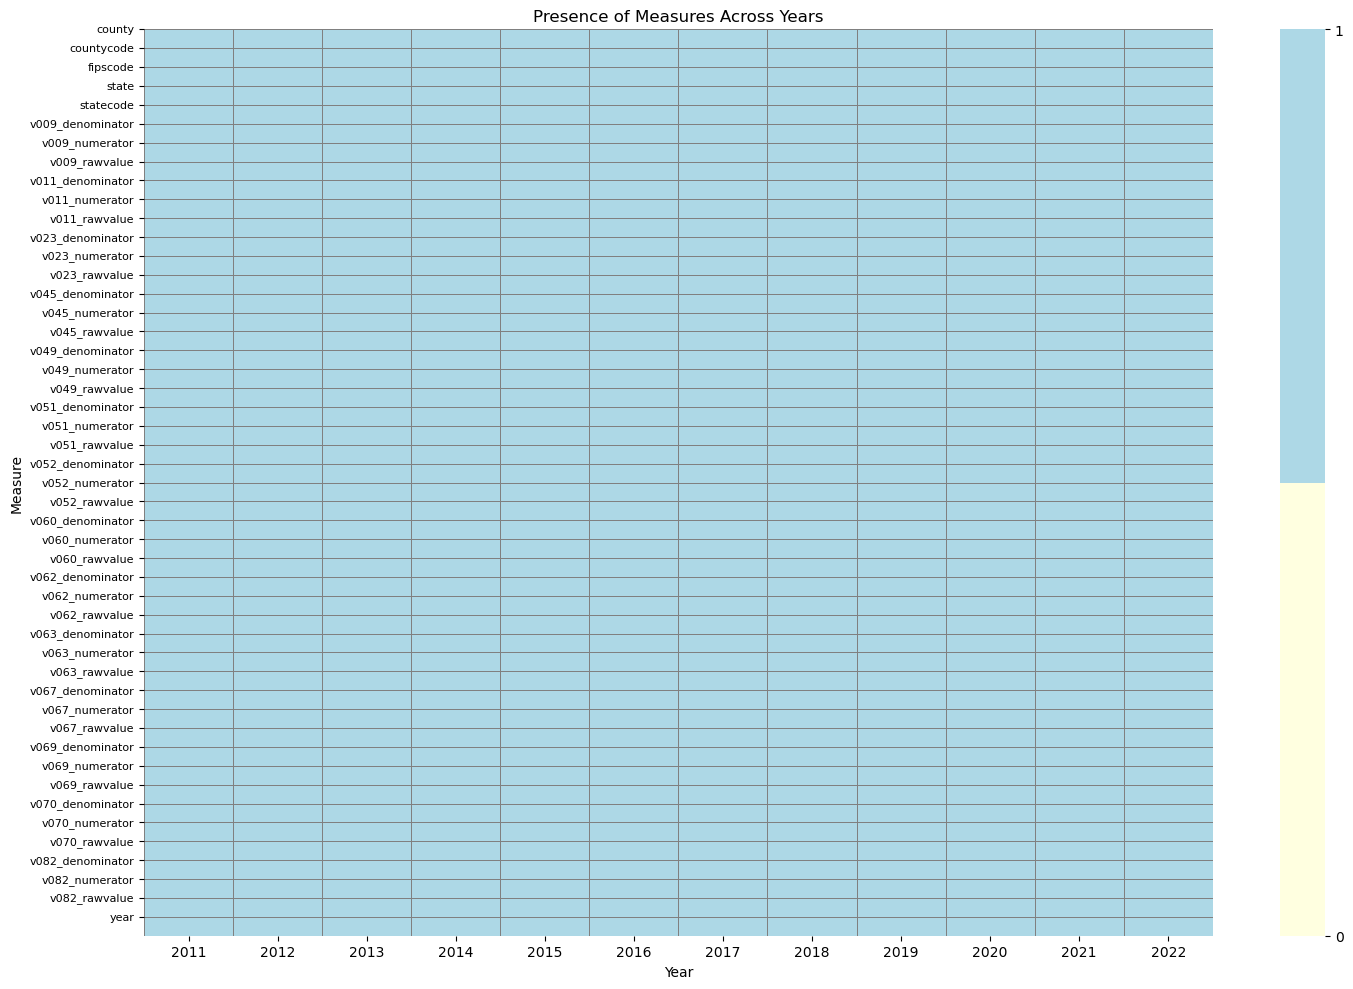

In [135]:
unique_measure_year = selected_dd[['Variable Name', 'Year']].drop_duplicates()
pivot_df = pd.pivot_table(unique_measure_year, index="Variable Name", columns="Year", 
                          aggfunc=lambda x: 1, fill_value=0)

pivot_df = pivot_df.sort_index()


colors = ["lightyellow", "lightblue"]
cmap = sns.color_palette(colors, as_cmap=True)

plt.figure(figsize=(15, 10))
ax = sns.heatmap(pivot_df, cmap=cmap, cbar=True, linewidths=0.5, linecolor='grey',
                 vmin=0, vmax=1, cbar_kws={"ticks": [0, 1]})

# Explicitly set all y-axis ticks
plt.yticks(ticks=range(len(pivot_df)), labels=pivot_df.index, fontsize=8)

plt.xlabel("Year")
plt.ylabel("Measure")
plt.title("Presence of Measures Across Years")

plt.tight_layout()
plt.savefig(f"{intermediate_dir}presence_of_measures_across_years.png", dpi=300, bbox_inches='tight')
plt.show()

> Similarly, we have also checked for each measure, if there are multiple variable names.

In [136]:
unique_measure = selected_dd.groupby('Measure')['Variable Name'].nunique()
unique_measure = unique_measure[unique_measure > 1].index
#selected_dd[selected_dd["Measure"].isin(unique_measure)]

In [137]:
data_dict_structured = {}

for _, row in df.iterrows():
    var_name = row["Variable Name"]
    measure = row["Measure"]
    description = row["Description"]
    year = row["Year"]
    
    if var_name not in data_dict_structured:
        data_dict_structured[var_name] = {
            "measures": set(),
            "descriptions": set(),
            "years": set()
        }
    
    data_dict_structured[var_name]["measures"].add(measure)
    data_dict_structured[var_name]["descriptions"].add(description)
    data_dict_structured[var_name]["years"].add(year)
    
# convert sets to lists
for var_name in data_dict_structured:
    data_dict_structured[var_name]["measures"] = list(data_dict_structured[var_name]["measures"])
    data_dict_structured[var_name]["descriptions"] = list(data_dict_structured[var_name]["descriptions"])
    data_dict_structured[var_name]["years"] = list(data_dict_structured[var_name]["years"])

(data_dict_structured)

{'statecode': {'measures': ['state fips code'],
  'descriptions': [None, ' '],
  'years': ['2016',
   '2017',
   '2012',
   '2018',
   '2019',
   '2020',
   '2015',
   '2022',
   '2021',
   '2011',
   '2014',
   '2013']},
 'countycode': {'measures': ['county fips code'],
  'descriptions': [None, ' '],
  'years': ['2016',
   '2017',
   '2012',
   '2018',
   '2019',
   '2020',
   '2015',
   '2022',
   '2021',
   '2011',
   '2014',
   '2013']},
 'fipscode': {'measures': ['5-digit fips code'],
  'descriptions': [None, ' '],
  'years': ['2016',
   '2017',
   '2012',
   '2018',
   '2019',
   '2020',
   '2015',
   '2022',
   '2021',
   '2011',
   '2014',
   '2013']},
 'state': {'measures': ['state abbreviation'],
  'descriptions': [None, ' '],
  'years': ['2016',
   '2017',
   '2012',
   '2018',
   '2019',
   '2020',
   '2015',
   '2022',
   '2021',
   '2011',
   '2014',
   '2013']},
 'county': {'measures': ['name'],
  'descriptions': [None, ' '],
  'years': ['2016',
   '2017',
   '2012',
   

In [138]:
selected_dd

,Year,Variable Name,Measure,Description
0,2011,statecode,state fips code,None
1,2011,countycode,county fips code,None
2,2011,fipscode,5-digit fips code,None
3,2011,state,state abbreviation,None
4,2011,county,name,None
...,...,...,...,...
3252,2022,v051_numerator,population numerator,
3253,2022,v051_denominator,population denominator,
3254,2022,v052_rawvalue,% below 18 years of age raw value,percentage of population below 18 years of age.
3255,2022,v052_numerator,% below 18 years of age numerator,


In [ ]:
selected_dd.to_csv(f"{intermediate_dir}{today}_selected_factors_all_year_dd.csv")

In [140]:
sorted(selected_dd['Variable Name'].unique())

['county',
 'countycode',
 'fipscode',
 'state',
 'statecode',
 'v009_denominator',
 'v009_numerator',
 'v009_rawvalue',
 'v011_denominator',
 'v011_numerator',
 'v011_rawvalue',
 'v023_denominator',
 'v023_numerator',
 'v023_rawvalue',
 'v045_denominator',
 'v045_numerator',
 'v045_rawvalue',
 'v049_denominator',
 'v049_numerator',
 'v049_rawvalue',
 'v051_denominator',
 'v051_numerator',
 'v051_rawvalue',
 'v052_denominator',
 'v052_numerator',
 'v052_rawvalue',
 'v060_denominator',
 'v060_numerator',
 'v060_rawvalue',
 'v062_denominator',
 'v062_numerator',
 'v062_rawvalue',
 'v063_denominator',
 'v063_numerator',
 'v063_rawvalue',
 'v067_denominator',
 'v067_numerator',
 'v067_rawvalue',
 'v069_denominator',
 'v069_numerator',
 'v069_rawvalue',
 'v070_denominator',
 'v070_numerator',
 'v070_rawvalue',
 'v082_denominator',
 'v082_numerator',
 'v082_rawvalue',
 'year']

### population_formulas

In [141]:
population_formulas = {
    'v051_rawvalue': {
        'formula': 'v051_rawvalue', 
        'description': 'Total population'
    },
    'v052_rawvalue': {
        'formula': 'v052_rawvalue * v051_rawvalue', 
        'description': 'Population under 18'
    }
}

### no_change_formulas

In [142]:
no_change_formulas = {}
no_change_variables = ['statecode', 'countycode', 'fipscode', 
                       'state', 'county', 'year']

for var in no_change_variables:
    no_change_formulas[var] = {
        'formula': var,
        'description': 'No change required'
    }
    

### adult_multiplication_formulas

In [143]:
adult_multiplication_formulas = {
    'v009_rawvalue': {
        'formula': 'v009_rawvalue * (1 - v052_rawvalue) * v051_rawvalue',
        'description': 'Adjusted total number of adults who are current smokers'
    },
    'v011_rawvalue': {
        'formula': 'v011_rawvalue * (1 - v052_rawvalue) * v051_rawvalue',
        'description': 'Adjusted total number of adults classified as obese'
    },
    'v049_rawvalue': {
        'formula': 'v049_rawvalue * (1 - v052_rawvalue) * v051_rawvalue',
        'description': 'Adjusted total number of adults reporting binge or heavy drinking'
    },
    'v060_rawvalue': {
        'formula': 'v060_rawvalue * (1 - v052_rawvalue) * v051_rawvalue',
        'description': 'Adjusted total number of adults aged 20 and above with diagnosed diabetes'
    }
}

### numerator_formulas

In [144]:
numerator_formulas = {
    'v070_numerator': {
        'formula': 'v070_numerator',
        'description': 'Total number of adults who answered "no" to the question, "During the past month, other than your regular job, did you participate in any physical activities or exercises such as running, calisthenics, golf, gardening, or walking for exercise?"'
    },
    'v069_numerator': {
        'formula': 'v069_numerator',
        'description': 'Total number of adults ages 25-44 with some post-secondary education.'
    },
    'v023_numerator': {
        'formula': 'v023_numerator',
        'description': 'Total number of population ages 16 and older unemployed but seeking work.'
    },
    'v082_numerator': {
        'formula': 'v082_numerator',
        'description': 'Total number of children that live in a household headed by single parent.'
    },
    'v062_numerator': {
        'formula': 'v062_numerator',
        'description': 'Total number of mental health care providers'
    },
    'v063_rawvalue': {
        'formula': 'v063_rawvalue',
        'description': 'The income where half of households in a county earn more and half of households earnless.'
    },
    'v067_numerator': {
        'formula': 'v067_numerator',
        'description': 'Total number of the workforce that drives alone to work.'
    }
    # ,
    # 'v140_numerator': {
    #     'formula': 'v140_numerator',
    #     'description': 'Number of membership associations'
    # }
}

### rate_based_formulas 

In [145]:
rate_based_formulas = {
    'v045_rawvalue': {
        'formula': 'v045_rawvalue',
        'description': 'Total newly diagnosed chlamydia cases in the county'
    }
}

## Update Data Dictionary
> Delete Variables

> Add formula and formula_description

In [146]:
dicts = [population_formulas, no_change_formulas, adult_multiplication_formulas,
    numerator_formulas, rate_based_formulas,]
kept_var = [key for d in dicts for key in d]
kept_var

['v051_rawvalue',
 'v052_rawvalue',
 'statecode',
 'countycode',
 'fipscode',
 'state',
 'county',
 'year',
 'v009_rawvalue',
 'v011_rawvalue',
 'v049_rawvalue',
 'v060_rawvalue',
 'v070_numerator',
 'v069_numerator',
 'v023_numerator',
 'v082_numerator',
 'v062_numerator',
 'v063_rawvalue',
 'v067_numerator',
 'v045_rawvalue']

In [ ]:
def update_data_dictionary(df, *formula_groups):
    filtered_df = df[df['Variable Name'].isin(kept_var)]
    filtered_df['formula'] = None
    filtered_df['formula_description'] = None

    for formula_group in formula_groups:
        for var_name, formula_info in formula_group.items():
            matching_rows = filtered_df['Variable Name'] == var_name
            filtered_df.loc[matching_rows, 'formula'] = formula_info['formula']
            filtered_df.loc[matching_rows, 'formula_description'] = formula_info['description']
    return filtered_df


updated_df = update_data_dictionary(
    selected_dd, 
    population_formulas,
    no_change_formulas,
    adult_multiplication_formulas,
    numerator_formulas,
    rate_based_formulas,
)
updated_df.to_csv(f"{intermediate_dir}{today}selected_factors_filtered_all_year_dd_withFormula.csv")

C:\Users\hongy\AppData\Local\Temp\ipykernel_29044\2772551174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['formula'] = None
C:\Users\hongy\AppData\Local\Temp\ipykernel_29044\2772551174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['formula_description'] = None


In [149]:
updated_df['Variable Name'].value_counts()

statecode         12
countycode        12
v051_rawvalue     12
v067_numerator    12
v063_rawvalue     12
v062_numerator    12
v070_numerator    12
v060_rawvalue     12
v082_numerator    12
v023_numerator    12
v069_numerator    12
v045_rawvalue     12
v049_rawvalue     12
v011_rawvalue     12
v009_rawvalue     12
year              12
county            12
state             12
fipscode          12
v052_rawvalue     12
Name: Variable Name, dtype: int64

# CHR csv Files

> Read files

In [150]:
CHR_csv = {}

for filename in os.listdir(data_dir):
    if re.match(r"^\d{4}CHR\.csv$", filename):
        year = filename[:4]
        filepath = os.path.join(data_dir, filename)
        CHR_csv[year] = pd.read_csv(filepath, skiprows=1)

In [151]:
var_names = updated_df["Variable Name"].unique()

In [152]:
len(var_names)

20

In [153]:
unique_variable_names = updated_df["Variable Name"].nunique()
total_variable_names = updated_df["Variable Name"].shape[0]
unique_measures = updated_df["Measure"].nunique()

print(f"Total unique variable names: {unique_variable_names}")
print(f"Total rows with variable names: {total_variable_names}")
print(f"Total unique measures: {unique_measures}")

Total unique variable names: 20
Total rows with variable names: 240
Total unique measures: 20


> Select columns in Each CSV

In [154]:
dataframes = []

for year, dataframe in CHR_csv.items():
    print(f"Year {year}: Original Shape {dataframe.shape}")
    selected_columns = [col for col in var_names if col in dataframe.columns]
    filtered_df = dataframe[selected_columns]
    dataframes.append(filtered_df)

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.head(3)

Year 2011: Original Shape (3193, 379)
Year 2012: Original Shape (3193, 330)
Year 2013: Original Shape (3193, 466)
Year 2014: Original Shape (3193, 487)
Year 2015: Original Shape (3193, 462)
Year 2016: Original Shape (3193, 482)
Year 2017: Original Shape (3195, 492)
Year 2018: Original Shape (3194, 508)
Year 2019: Original Shape (3194, 534)
Year 2020: Original Shape (3194, 786)
Year 2021: Original Shape (3194, 690)
Year 2022: Original Shape (3194, 725)


,statecode,countycode,fipscode,state,county,year,v009_rawvalue,v011_rawvalue,v049_rawvalue,v045_rawvalue,v069_numerator,v023_numerator,v082_numerator,v060_rawvalue,v070_numerator,v062_numerator,v063_rawvalue,v067_numerator,v051_rawvalue,v052_rawvalue
0,0,0,0.0,US,United States,2011.0,NaN,0.266,NaN,401.3,49957087.0,NaN,23106795.0,NaN,NaN,123740.0,52029.0,105185519.0,NaN,NaN
1,1,0,1000.0,AL,Alabama,2011.0,0.236,0.319,0.126,535.0,679290.0,NaN,402956.0,0.119,NaN,926.0,42586.0,1650966.0,4708708.0,0.239
2,1,1,1001.0,AL,Autauga County,2011.0,0.274,0.315,0.141,307.8,7660.0,2143.0,4119.0,0.114,NaN,1.0,51622.0,19529.0,50756.0,0.278


> Sort Column Names in combined_df

In [155]:
combined_df = combined_df[sorted(combined_df.columns)]

In [ ]:
combined_df.to_csv(f"{intermediate_dir}{today}original_combined_chr.csv")

## Calculation

Though the name contains %, they are all less than 1. Based on empiral experience and manual check, we regard it as ratio

In [157]:
def preprocess_formula(formula, df_columns):
    for col in df_columns:
        formula = formula.replace(col, f'combined_df["{col}"]')
    return formula

def apply_formulas_and_rename_columns(combined_df, *formula_groups):
    for formula_group in formula_groups:
        for var_name, formula_info in formula_group.items():
            if var_name in combined_df.columns:
                formula = formula_info.get('formula')

                if formula == var_name:
                    combined_df[f'A_{var_name}'] = combined_df[var_name]
                    print(f"Directly copied {var_name} without modification as per formula.")
                elif formula:
                    processed_formula = preprocess_formula(formula, combined_df.columns)

                    try:
                        combined_df[f'A_{var_name}'] = eval(processed_formula)
                        print(f"Calculated for {var_name} with formula: {processed_formula}")
                    except Exception as e:
                        print(f"Error in calculating formula for {var_name}: {e}")
                # else:
                #     # Fallback to copying if formula is None (in case this check is needed)
                #     combined_df[f'A_{var_name}'] = combined_df[var_name]
                #     print(f"Directly copied {var_name} as a fallback.")
            else:
                print(f"Column missing for {var_name}")
    return combined_df



processed_df = apply_formulas_and_rename_columns(
    combined_df,
    population_formulas,
    no_change_formulas,
    adult_multiplication_formulas,
    numerator_formulas,
    rate_based_formulas,
)

Directly copied v051_rawvalue without modification as per formula.
Calculated for v052_rawvalue with formula: combined_df["v052_rawvalue"] * combined_df["v051_rawvalue"]
Directly copied statecode without modification as per formula.
Directly copied countycode without modification as per formula.
Directly copied fipscode without modification as per formula.
Directly copied state without modification as per formula.
Directly copied county without modification as per formula.
Directly copied year without modification as per formula.
Calculated for v009_rawvalue with formula: combined_df["v009_rawvalue"] * (1 - combined_df["v052_rawvalue"]) * combined_df["v051_rawvalue"]
Calculated for v011_rawvalue with formula: combined_df["v011_rawvalue"] * (1 - combined_df["v052_rawvalue"]) * combined_df["v051_rawvalue"]
Calculated for v049_rawvalue with formula: combined_df["v049_rawvalue"] * (1 - combined_df["v052_rawvalue"]) * combined_df["v051_rawvalue"]
Calculated for v060_rawvalue with formula: c

In [158]:
processed_df

,county,countycode,fipscode,state,statecode,v009_rawvalue,v011_rawvalue,v023_numerator,v045_rawvalue,v049_rawvalue,v051_rawvalue,v052_rawvalue,v060_rawvalue,v062_numerator,v063_rawvalue,v067_numerator,v069_numerator,v070_numerator,v082_numerator,year,A_v051_rawvalue,A_v052_rawvalue,A_statecode,A_countycode,A_fipscode,A_state,A_county,A_year,A_v009_rawvalue,A_v011_rawvalue,A_v049_rawvalue,A_v060_rawvalue,A_v070_numerator,A_v069_numerator,A_v023_numerator,A_v082_numerator,A_v062_numerator,A_v063_rawvalue,A_v067_numerator,A_v045_rawvalue
0,United States,0,0.0,US,0,NaN,0.266,NaN,401.3,NaN,NaN,NaN,NaN,123740.0,52029.0,105185519.0,49957087.0,NaN,23106795.0,2011.0,NaN,NaN,0,0,0.0,US,United States,2011.0,NaN,NaN,NaN,NaN,NaN,49957087.0,NaN,23106795.0,123740.0,52029.0,105185519.0,401.3
1,Alabama,0,1000.0,AL,1,0.236,0.319,NaN,535.0,0.126000,4708708.0,0.239000,0.119,926.0,42586.0,1650966.0,679290.0,NaN,402956.0,2011.0,4708708.0,1.125381e+06,1,0,1000.0,AL,Alabama,2011.0,845665.121968,1.143081e+06,451499.175288,426415.887772,NaN,679290.0,NaN,402956.0,926.0,42586.0,1650966.0,535.0
2,Autauga County,1,1001.0,AL,1,0.274,0.315,2143.0,307.8,0.141000,50756.0,0.278000,0.114,1.0,51622.0,19529.0,7660.0,NaN,4119.0,2011.0,50756.0,1.411017e+04,1,1,1001.0,AL,Autauga County,2011.0,10040.957968,1.154344e+04,5167.062312,4177.624848,NaN,7660.0,2143.0,4119.0,1.0,51622.0,19529.0,307.8
3,Baldwin County,3,1003.0,AL,1,0.219,0.262,7094.0,226.4,0.194000,179878.0,0.231000,0.098,29.0,51957.0,63562.0,26292.0,NaN,11557.0,2011.0,179878.0,4.155182e+04,1,3,1003.0,AL,Baldwin County,2011.0,30293.433858,3.624146e+04,26835.279308,13555.965836,NaN,26292.0,7094.0,11557.0,29.0,51957.0,63562.0,226.4
4,Barbour County,5,1005.0,AL,1,0.229,0.376,1271.0,474.3,0.085000,29737.0,0.223000,0.136,2.0,30896.0,8347.0,2869.0,NaN,3569.0,2011.0,29737.0,6.631351e+03,1,5,1005.0,AL,Barbour County,2011.0,5291.193621,8.687724e+03,1963.980165,3142.368264,NaN,2869.0,1271.0,3569.0,2.0,30896.0,8347.0,474.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38318,Sweetwater County,37,56037.0,WY,56,0.170,0.335,1532.0,349.5,0.176325,42673.0,0.254095,0.083,105.0,70583.0,16120.0,7490.0,NaN,1774.0,2022.0,42673.0,1.084300e+04,56,37,56037.0,WY,Sweetwater County,2022.0,5411.100000,1.066305e+04,5612.432067,2641.890000,NaN,7490.0,1532.0,1774.0,105.0,70583.0,16120.0,349.5
38319,Teton County,39,56039.0,WY,56,0.113,0.222,912.0,332.4,0.193689,23497.0,0.177086,0.066,128.0,92488.0,9685.0,6344.0,NaN,773.0,2022.0,23497.0,4.161000e+03,56,39,56039.0,WY,Teton County,2022.0,2184.968000,4.292592e+03,3745.177664,1276.176000,NaN,6344.0,912.0,773.0,128.0,92488.0,9685.0,332.4
38320,Uinta County,41,56041.0,WY,56,0.188,0.298,582.0,267.0,0.181873,20215.0,0.277418,0.083,74.0,71246.0,7653.0,3015.0,NaN,628.0,2022.0,20215.0,5.608000e+03,56,41,56041.0,WY,Uinta County,2022.0,2746.116000,4.352886e+03,2656.623943,1212.381000,NaN,3015.0,582.0,628.0,74.0,71246.0,7653.0,267.0
38321,Washakie County,43,56043.0,WY,56,0.176,0.289,211.0,192.2,0.190701,7760.0,0.219845,0.089,31.0,58532.0,3182.0,1137.0,NaN,292.0,2022.0,7760.0,1.706000e+03,56,43,56043.0,WY,Washakie County,2022.0,1065.504000,1.749606e+03,1154.502489,538.806000,NaN,1137.0,211.0,292.0,31.0,58532.0,3182.0,192.2


In [159]:
processed_df.shape

(38323, 40)

In [161]:
processed_df.to_csv(f"{intermediate_dir}{today}combinedCHR_selectedColumns_withCalculation.csv", index=False)

# Save the Final csv

In [170]:
onlyCalc_df = processed_df[
    [
        col for col in processed_df.columns 
        if (col.startswith("A_")) #and col.endswith("rawvalue")) 
        or col in ["county", "countycode", "fipscode", "state", "statecode", "year"]
    ]
].copy()
onlyCalc_df.columns = [col[2:] if col.startswith("A_") else col for col in onlyCalc_df.columns]
onlyCalc_df = onlyCalc_df.iloc[1:,:]
onlyCalc_df.to_csv(f"{intermediate_dir}{today}combinedCHR_selectedColumns_onlyCalculation.csv", index=False)

In [171]:
onlyCalc_df.columns

Index(['county', 'countycode', 'fipscode', 'state', 'statecode', 'year',
       'v051_rawvalue', 'v052_rawvalue', 'statecode', 'countycode', 'fipscode',
       'state', 'county', 'year', 'v009_rawvalue', 'v011_rawvalue',
       'v049_rawvalue', 'v060_rawvalue', 'v070_numerator', 'v069_numerator',
       'v023_numerator', 'v082_numerator', 'v062_numerator', 'v063_rawvalue',
       'v067_numerator', 'v045_rawvalue'],
      dtype='object')

In [172]:
onlyCalc_df.shape

(38322, 26)

In [173]:
onlyCalc_df.head(3)

,county,countycode,fipscode,state,statecode,year,v051_rawvalue,v052_rawvalue,statecode,countycode,fipscode,state,county,year,v009_rawvalue,v011_rawvalue,v049_rawvalue,v060_rawvalue,v070_numerator,v069_numerator,v023_numerator,v082_numerator,v062_numerator,v063_rawvalue,v067_numerator,v045_rawvalue
1,Alabama,0,1000.0,AL,1,2011.0,4708708.0,1125381.212,1,0,1000.0,AL,Alabama,2011.0,845665.121968,1.143081e+06,451499.175288,426415.887772,NaN,679290.0,NaN,402956.0,926.0,42586.0,1650966.0,535.0
2,Autauga County,1,1001.0,AL,1,2011.0,50756.0,14110.168,1,1,1001.0,AL,Autauga County,2011.0,10040.957968,1.154344e+04,5167.062312,4177.624848,NaN,7660.0,2143.0,4119.0,1.0,51622.0,19529.0,307.8
3,Baldwin County,3,1003.0,AL,1,2011.0,179878.0,41551.818,1,3,1003.0,AL,Baldwin County,2011.0,30293.433858,3.624146e+04,26835.279308,13555.965836,NaN,26292.0,7094.0,11557.0,29.0,51957.0,63562.0,226.4
